In [ ]:
from tensorflow import lite

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras

In [ ]:
from tensorflow.keras import layers

In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
import random, os

In [ ]:
import shutil

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from matplotlib.image import imread

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.metrics import categorical_accuracy

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/image classification/dataset/train.csv')

In [ ]:
import os

In [ ]:
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative_DR'
}

df['binary_type'] = df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferative_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

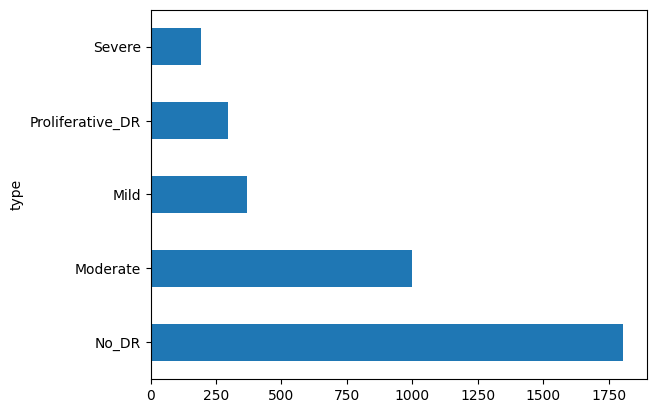

In [ ]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

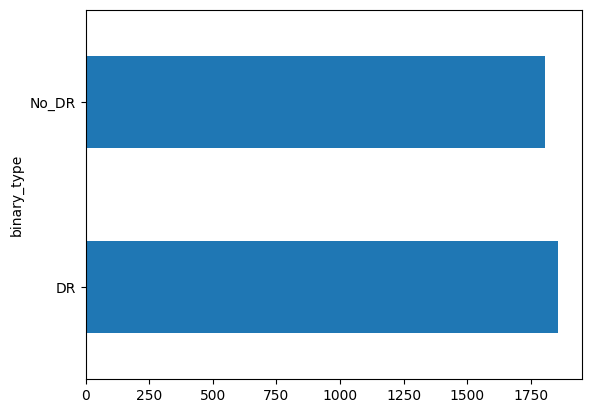

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

In [ ]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR               1263
Moderate             699
Mild                 258
Proliferative_DR     207
Severe               135
Name: count, dtype: int64 

type
No_DR               271
Moderate            150
Mild                 56
Proliferative_DR     44
Severe               29
Name: count, dtype: int64 

type
No_DR               271
Moderate            150
Mild                 56
Proliferative_DR     44
Severe               29
Name: count, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [ ]:
src_dir = r'/content/drive/MyDrive/image classification/dataset/train_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"

    # Attempt to find the file with the diagnosis subfolder
    srcfile = os.path.join(src_dir, diagnosis, id_code)

    # If file doesn't exist in the diagnosis folder, look in the main folder
    if not os.path.exists(srcfile):
        srcfile = os.path.join(src_dir, id_code)

    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"

    srcfile = os.path.join(src_dir, diagnosis, id_code)
    if not os.path.exists(srcfile):
        srcfile = os.path.join(src_dir, id_code)

    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"

    srcfile = os.path.join(src_dir, diagnosis, id_code)
    if not os.path.exists(srcfile):
        srcfile = os.path.join(src_dir, id_code)

    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(srcfile, dstfile)


In [ ]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Building the model
model = tf.keras.Sequential([
    layers.Input(shape=(224,224,3)),  # Define the input shape using Input layer
    layers.Conv2D(8, (3,3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

# Compile the model with corrected optimizer parameter
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

# Fit the model
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 514s 6s/step - acc: 0.7689 - loss: 0.5263 - val_acc: 0.5073 - val_loss: 0.6822
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 533s 6s/step - acc: 0.8907 - loss: 0.2672 - val_acc: 0.5145 - val_loss: 0.6496
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 485s 6s/step - acc: 0.9215 - loss: 0.2222 - val_acc: 0.7291 - val_loss: 0.5641
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 481s 6s/step - acc: 0.9117 - loss: 0.2173 - val_acc: 0.8782 - val_loss: 0.4438
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 498s 6s/step - acc: 0.9266 - loss: 0.2063 - val_acc: 0.9091 - val_loss: 0.3332
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 473s 5s/step - acc: 0.9357 - loss: 0.1940 - val_acc: 0.9164 - val_loss: 0.2465
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 468s 5s/step - acc: 0.9287 - loss: 0.2020 - val_acc: 0.9200 - val_loss: 0.2174
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - acc: 0.9419 - loss: 0.1724 - val_acc: 0.9218 - val_loss: 0.2039
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 463s 5s/step - acc: 0.9404 - loss: 0.

In [ ]:
model.save('/content/drive/MyDrive/Trained Model/DRmodel.keras')

In [ ]:
loss, acc = model.evaluate(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - acc: 0.9343 - loss: 0.1660
Accuracy:  0.9418181777000427


In [ ]:
# List the files in your directory to verify the exact path
import os
print(os.listdir('/content/drive/MyDrive/Trained Model'))

['DRmodel.keras']


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Trained Model/DRmodel.keras')

In [ ]:
import cv2
def predict_class(path):
    img = cv2.imread(path)
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = model
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
DR


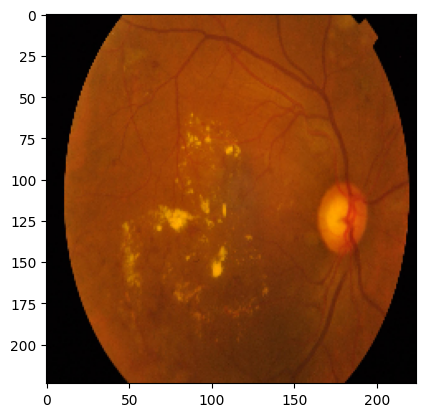

In [ ]:
predict_class('/content/test/DR/2ba0b0d9bda2.png')